# Bayesian inference

## [Scientific Computing with Python](http://scicompy.yoavram.com)
## Yoav Ram

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize
import numba # high performance computing
import emcee # conda install emcee
import seaborn as sns
sns.set_context('talk')

red, blue, green = sns.color_palette('Set1', 3)

In the previous lecture we discusses the frequentist approach to statistical inference using maximum likelihood.
Today we will discuss the Bayesian approach.

Bayesian inference is a method of statistical inference in which Bayes' theorem is used to update the probability for a hypothesis as more evidence or information becomes available. 

# Bayes' theorem
Consider the events $A$ and $B$, then Bayes' theorem states that

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Applied to model-based inference, we define:
- $\theta$ - the model parameters
- $X$ - the data
and we have

$$
P(\theta \mid X) = \frac{P(X \mid \theta) P(\theta)}{P(X)}
$$
where
- $P(\theta)$ is called the **prior probability** that formulates our beliefs about the model before seeing any data
- $P(X \mid \theta)$ is the probability of observing $X$ given $\theta$, what we called the **likelihood** of $\theta$
- $P(\theta \mid X)$ is called the **posterior probability**, that is, how our beliefs about the model changed due to observing the data
- $P(X)$ is the probability of observing the data unconditioned on the model; we usually ignore it as it does not depend on the model

In Bayesian inference we attempt to estimate the posterior distribution over the model parameters; this constrast with classical/frequentist approaches like *maximum likelihood* in which we attempt to estimate a point estimate of the parameters - a single parameter value.

# Simple model for photon counts

This example follows a [blog post by Jake VanDerPlas](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/).

Imagine that we point our telescope to the sky, and observe the light coming from a single star. For the time being, we'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $\mu$ (we'll also ignore effects like sky noise and other sources of systematic error). We'll assume that we perform a series of $n$ measurements with our telescope, where the $i^{\rm th}$ measurement reports the observed photon flux $x_i$.

$$
x_i \sim Poi(\mu)
$$

The question is, given this set of measurements $\{x_i\}$, what is our best estimate of the true flux $\mu$?

We start by generating some data.

In [10]:
np.random.seed(1)

# true flux: number of photons measured in 1 second
μ = 1000  
# number of measurements
n = 50 
# n measurements of the flux
X = np.random.poisson(μ, size=n)

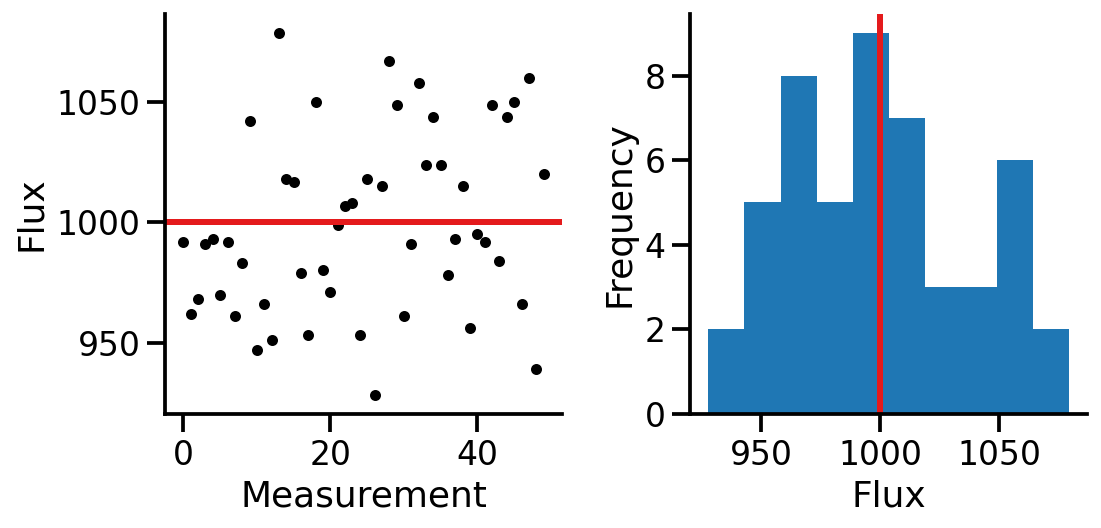

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement")
ax.set_ylabel("Flux")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux")

fig.tight_layout()
sns.despine()

In this toy example we already know the
true flux $\mu$, but the question is this: **given our measurements and errors, what is our best estimate of the true flux?**

We have previously developed the log-likelihood function:

In [12]:
def log_likelihood(μ, X):
    return scipy.stats.poisson(μ).logpmf(X).sum()

And we found that the maximum likelihood estimate $\hat{\mu}$ is the _arithmetic mean_.

μ = 1000 
μ_hat = 999.04


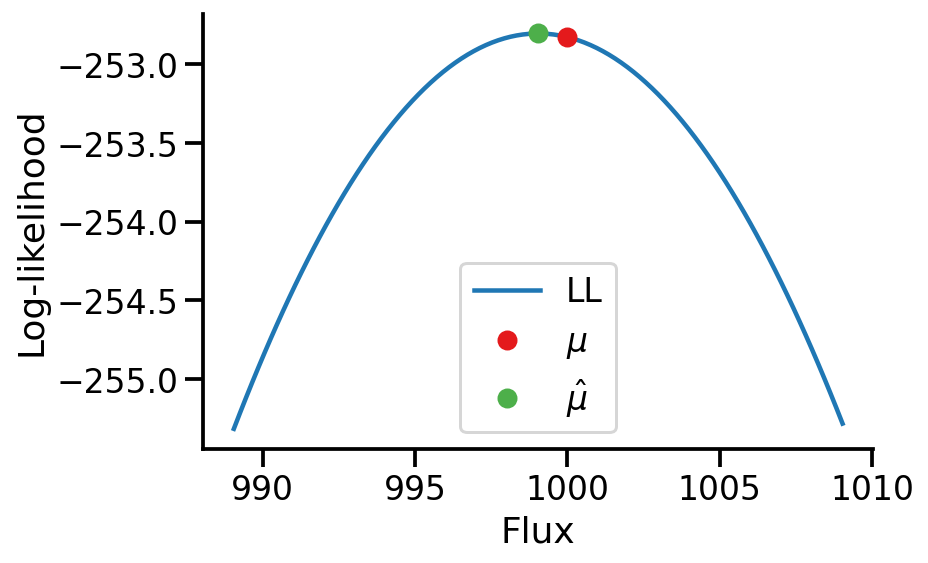

In [14]:
μ_hat = X.mean()
print("μ = {} \nμ_hat = {}".format(μ, μ_hat))

μ_range = np.linspace(μ_hat*0.99, μ_hat*1.01, 100)
plt.plot(μ_range, [log_likelihood(μ_, X) for μ_ in μ_range], label='LL')
plt.plot(μ, log_likelihood(μ, X), 'o', color=red, label='$μ$')
plt.plot(μ_hat, log_likelihood(μ_hat, X), 'o', color=green, label='$\hat{μ}$')

plt.xlabel("Flux")
plt.ylabel("Log-likelihood")
plt.legend()
sns.despine()

## Bayesian inference

In the Bayesian approach, we want to compute the  posterior distribution of the model parameter
$$
P(\mu \mid X) = \frac{P(X \mid \mu) P(\mu)}{P(X)},
$$
which reflects our knowledge or beliefe on the parameter $\mu$.

We can't compute $P(X)$, but given a definition of the prior $P(\mu)$ and likelihood $P(X \mid \mu)$ we can compute the posterior $P(\mu \mid X)$ for any $\mu$ up to a constant -- that constant is $P(X)$.
So if we then normalize we can get the posterior.

Let's assume the prior is uniform in the positive values:

$$
P(\mu = x) = \begin{cases}
1, & x > 0 \\
0, & \text{otherwise}
\end{cases}
$$


Therefore the log-prior is:

$$
logP(\mu = x) = \begin{cases}
0, & x > 0 \\
-\infty, & \text{otherwise}
\end{cases}
$$


We already have a definition for the log-likelihood in the form of the above `log_likelihood` function, which computes:
$$
logP(X \mid \mu) = \log\mathcal{L}(\mu |X) = 
\sum_{i=1}^{n}{X_i \log{\mu} -\mu -\log{(X_i!)}}
$$
where $X_i$ ($1 \le i \le n$) are the data points in $X$.

In [15]:
def log_prior(μ):
    if μ > 0:
        return 0
    else:
        return -np.inf

def log_posterior(μ, X):
    logpr = log_prior(μ)
    if np.isinf(logpr): 
        return logpr
    else: 
        return logpr + log_likelihood(μ, X)

This is a one-dimensional problem, so we can work with a direct approach; that won't work with multi-dimensional problems, and therefore it is common to use sampling methods such as _Markov chain Monte Carlo_, or _MCMC_.

Let's do it anyway.
Since we can't compute for every positive $\mu$ lets just do it for $min(X) < \mu < max(X)$, as we can assume the posterior probability is very small for $\mu$ values that outside the range of the data.

Our point estimate will be the maximum of the posterior (i.e. _MAP_), rather than that of the likelihood (although there is not differene in this case because of the uniform prior).

In [16]:
μ_range = np.linspace(X.min(), X.max(), 100)
pri = np.exp([log_prior(μ_) for μ_ in μ_range])
lik = np.exp([log_likelihood(μ_, X) for μ_ in μ_range])
post = np.exp([log_posterior(μ_, X) for μ_ in μ_range])
μ_hat = μ_range[post.argmax()] # maximum a posterioi estimate

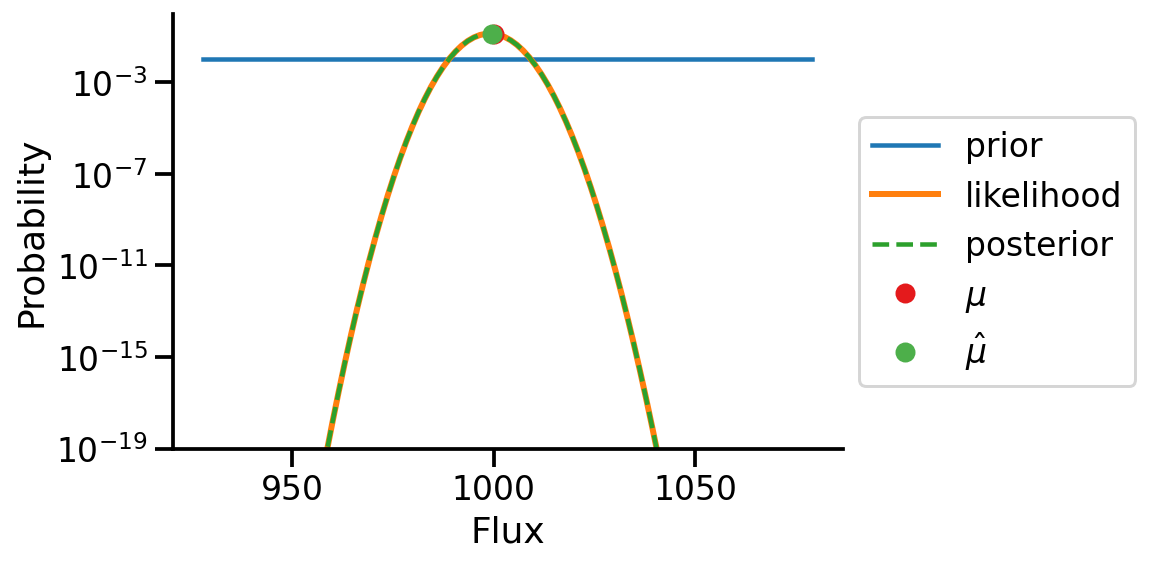

In [17]:
plt.plot(μ_range, pri/pri.sum(), label='prior')
plt.plot(μ_range, lik/lik.sum(), lw=3, label='likelihood')
plt.plot(μ_range, post/post.sum(), ls='--', label='posterior')
plt.plot(μ, np.exp(log_posterior(μ, X))/post.sum(), 'o', color=red, label='$μ$')
plt.plot(μ_hat, np.exp(log_likelihood(μ_hat, X))/post.sum(), 'o', color=green, label='$\hat{μ}$')

plt.xlabel("Flux")
plt.ylabel("Probability")
plt.yscale('log')
plt.ylim(1e-19, 1)
plt.legend(bbox_to_anchor=(1, 0.8))
sns.despine()

## Exercise

Change the prior to something more informative - say a gaussian around the mean of the data -- and plot the prior, likelihood, and posterior again.

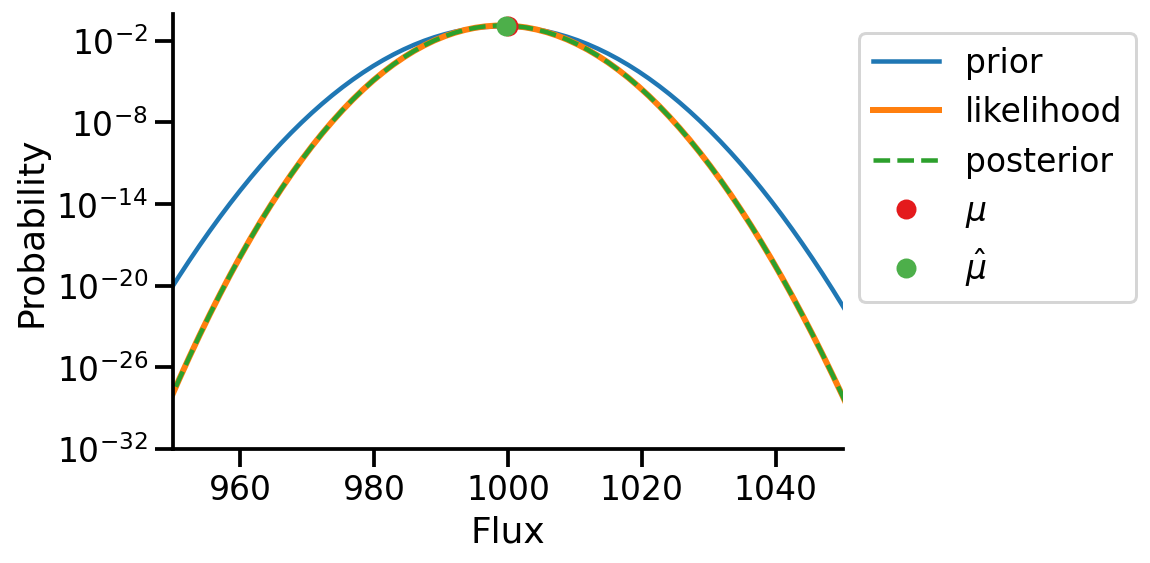

# Sampling

For anything that has more than one or two parameters we cannot do the above exhustive method as the complexity increases with the number of parameters (or the dimension of the parameter space).

A common approach is therefore to use Monte Carlo or sampling methods, in which instead of directly computing the prior distribution, we indirectly sample from it.

The simplest method for sampling is rejection sampling 

## Rejection sampling

Given empirical data $X$, a model parameterized by the vector $\theta$, a prior $P(\theta)$, and likelihood $P(X \mid \theta)$, the following describes the *rejection sampling algorithm*:

1. Generate candidate parameter value from the prior $\theta^* \sim P(\theta)$  
1. Compute the likelihood for the candidate parameter $P(X \mid \theta^*)$
1. Accept $\theta^*$ with probability $P(X \mid \theta^*)$.

This process effectivelty samples from the posterior, as the probability to draw $\theta^*$ proportinal to $P(X \mid \theta^*) P(\theta^*)$. 

Therefore, the collection of accepted $\theta^*$ values _approximates_ the posterior distribution $P(\theta \mid x)$.

The proportion of accepted values is caleld the __acceptance rate__, and it can be very low if the prior is very different from the posterior (which frequently occurs if we don't know much about the parameter values). For example, if we run the following with a "flat" (uniform) prior, we will get an acceptance rate of about 1:100,000.
With an informative prior - a Gaussian around the mean of the data - we still only have an acceptance rate of about 1:10,000.

So we have to take at least 100,000 samples, and the running time is therefore long.

In [126]:
N = 1000
# sample from prior
prior = scipy.stats.norm(X.mean(), X.std()/np.sqrt(X.size))
μs = prior.rvs(N) 
# accept or reject according to likelihood/prior
log_liks = np.array([log_likelihood(μ_, X) for μ_ in μs]) # compute log-likelihood
liks = np.exp(log_liks) # exponentiate to get likelihood
liks /= liks.sum() # normalize
liks /= prior.pdf(μs) # divide by prior
randoms = np.random.random(N) # draw randoms
accepted = randoms < liks # accept or reject
accept_rate = accepted.mean()
print("Acceptance rate: ", accept_rate)

Acceptance rate:  0.012


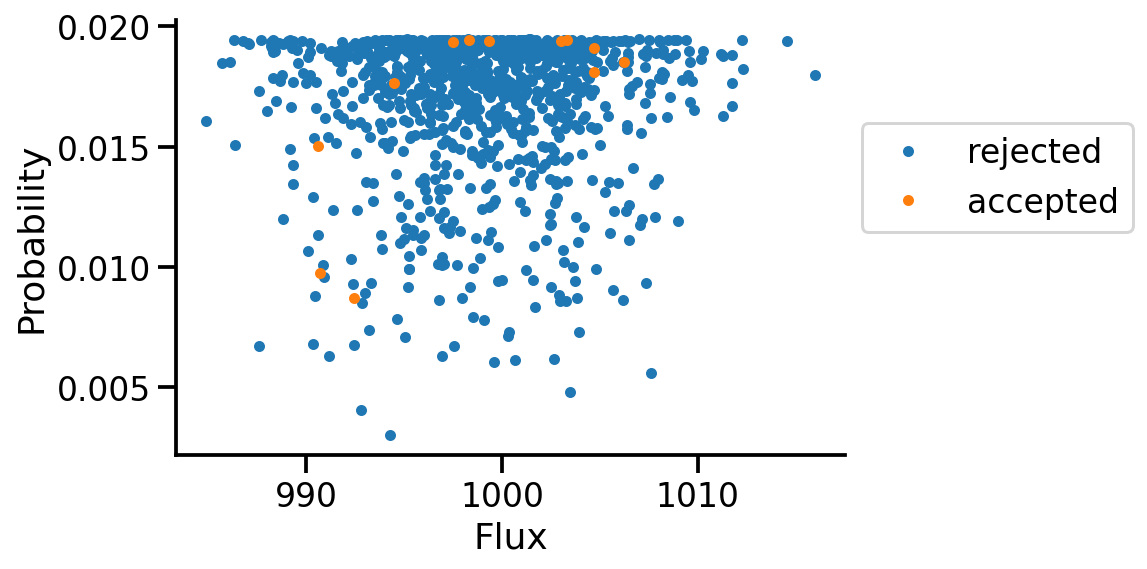

In [147]:
μs.sort()
plt.plot(μs[~accepted], liks[~accepted], '.', label='rejected')
plt.plot(μs[accepted], liks[accepted], '.', label='accepted')
plt.legend(bbox_to_anchor=(1, 0.8))
plt.xlabel('Flux')
plt.ylabel('Probability')
sns.despine()

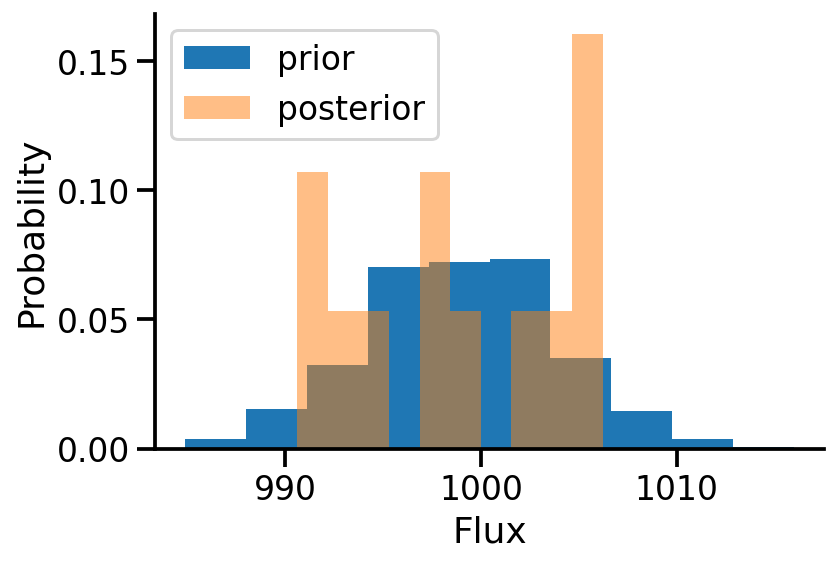

In [154]:
plt.hist(μs, density=True, label='prior')
plt.hist(μs[accepted], density=True, alpha=0.5, label='posterior')
plt.legend()
plt.xlabel('Flux')
plt.ylabel('Probability')
sns.despine()

The problem with the rejection method is that the acceptance rate can be very low, which requires us to draw many samples from the prior, and compute the log-likelihood many times, and this is very wasteful.

We'll deal with that in the next section.

## Markov chain Monte Carlo: MCMC

Markov chain Monte Carlo is a family of clever algorithms for sampling with the prior with a much higher acceptance rate by concentrating on the areas of high likelihood.

We create "chains" of accepted parameter samples of length $N$ using the following algorithm.

The most well-known, maybe, of these algorithms is the **Metropolis–Hastings** algorithm.

We start at iteration $i$ with an initial parameter $\theta_i$ drawn from the prior.

At each iteration,
1. Generate a candidate parameter value $\theta^*$ from a proposal distribution: $\theta^* \sim N(\theta_i, \eta)$ - this allows the chain to "explore" the parameter space ($\eta$ is an "exploration rate" or "learning rate).
1. Compute the likelihood $P(X \mid \theta^*)$.
1. Set the acceptance probability $\alpha=\frac{P(X \mid \theta^*)}{P(X \mid \theta_i)}$.
1. Set $\theta_{i+1} = \theta^*$ with probability $min(1,\alpha)$ (i.e. accept $\theta^*$), otherwise set $\theta_{i+1} = \theta_i$ (i.e. reject $\theta^*$ and keep $\theta_i$ again).


_Note:_
in the more general case, we can use a proposal distribution $q(\theta \mid \theta_i)$ and then we set $\alpha = \frac{P(X \mid \theta^*) q(\theta_i \mid \theta^*)}{P(X \mid \theta_i) q(\theta^* \mid \theta_i)}$. If we use the gaussian proposal distribution, then it is symmetric around the mean $q(\theta_i \mid \theta^*) = q(\theta^* \mid \theta_i)$, and $\alpha$ simplifies.

This sampling algorithm is much more efficient than the rejection sampling, as it is able to "spend more time" in areas of high likelihood.

However, this algorithm can get stuck on areas of low likelihood.

Text(0.5, 0, 'Value of random variable')

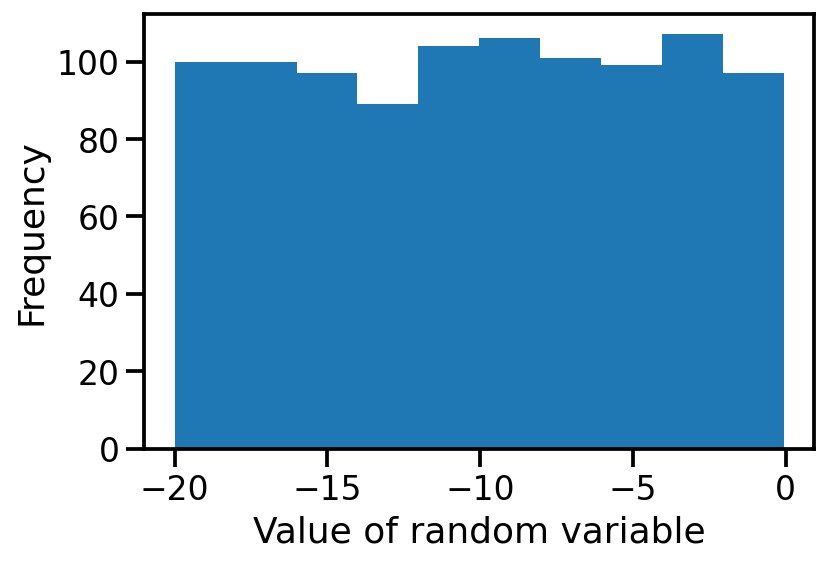

In [19]:
a,b = 1e-20, 1
r = scipy.stats.loguniform.rvs(a, b, size=1000)
fig, ax = plt.subplots(1, 1)
ax.hist(np.log10(r))
ax.set_ylabel("Frequency")
ax.set_xlabel("Value of random variable")

In [20]:
η = 0.5 # proposal width, exploration rate
N = 10000 # chain length
burnin = N // 2 # the first 50% of samples are removed, used only to get closer to the real value
accept = 0

μ_samples = np.empty(N)
μ_samples[0] = np.random.uniform(X.min(), X.max()) # initial guess drawn from prior
loglik = log_likelihood(μ_samples[0], X)
# prepare random numbers for efficiency
proposals = np.random.normal(0, η, size=N)
loguniforms = np.log(np.random.random(size=N))

# start the chain
for i in range(1, N):
    # generate candidate
    μ_candidate = μ_samples[i-1] + proposals[i]
    # compute log-likelihood
    loglik_candidate = log_likelihood(μ_candidate, X)
    # compute acceptance log-probability
    logα = loglik_candidate - loglik # = log(lik_candidate/lik)
    # accept / reject
    if logα > loguniforms[i]: # accept
        loglik = loglik_candidate
        μ_samples[i] = μ_candidate
        accept += 1
    else: # reject
        μ_samples[i] = μ_samples[i-1]
         
accept_rate = accept / N
print("Acceptance rate:", accept_rate)

Acceptance rate:  0.9617


We can see that the acceptance rate is much higher.

Lets look at the chain using a _trace plot_.

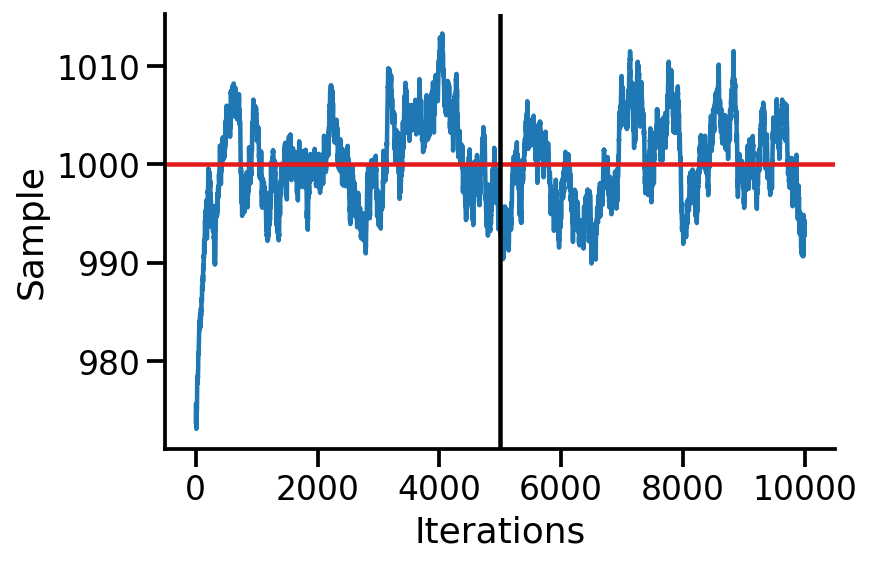

In [21]:
plt.plot(μ_samples)
plt.axhline(μ, color=red)
plt.axvline(burnin, color='k')
plt.xlabel('Iterations')
plt.ylabel('Sample')
sns.despine()

This looks good - the samples fluctuate around the true parameter (red line), and we can see that the chain seemed to have settled by the burnin time (vertical black line).

In [22]:
μ_samples = μ_samples[burnin:]

Now we can look at the posterior. Since it is unimodal, we can take the mean as a good stimate of the max.

μ = 1000 
μ_hat = 1000.12 +/- 4.41


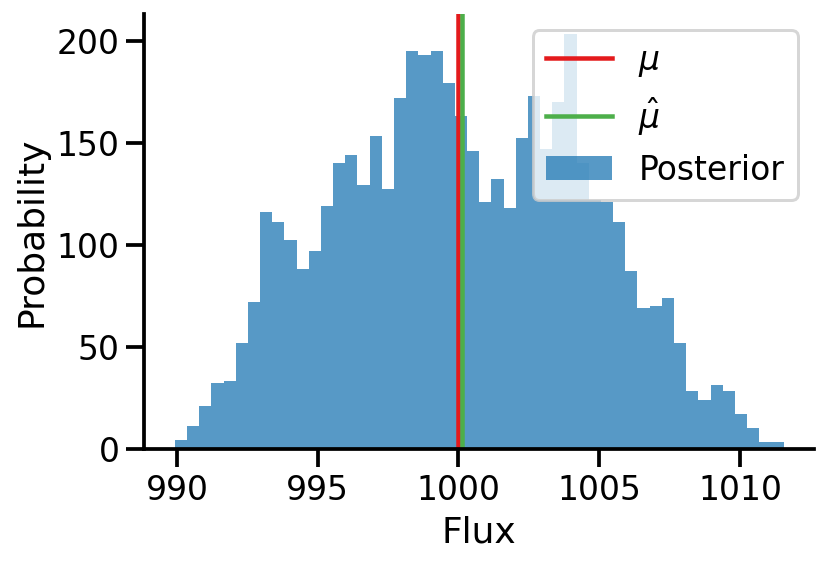

In [23]:
μ_hat = μ_samples.mean()
σ_hat = μ_samples.std()

print("μ = {} \nμ_hat = {:.2f} +/- {:.2f}".format(
    μ, μ_hat, σ_hat))

plt.hist(μ_samples, bins=50, alpha=0.75, label='Posterior')
plt.axvline(μ, color=red, label=r'$\mu$')
plt.axvline(μ_hat, color=green, label=r'$\hat{\mu}$')

plt.xlabel("Flux")
plt.ylabel("Probability")
plt.legend()
sns.despine()

Other interesting diagnostics we can do are to look at the differences between consecutive samples.
Their distribution should match the proposal distribution $N(0, \eta)$, ploted below as a black line.

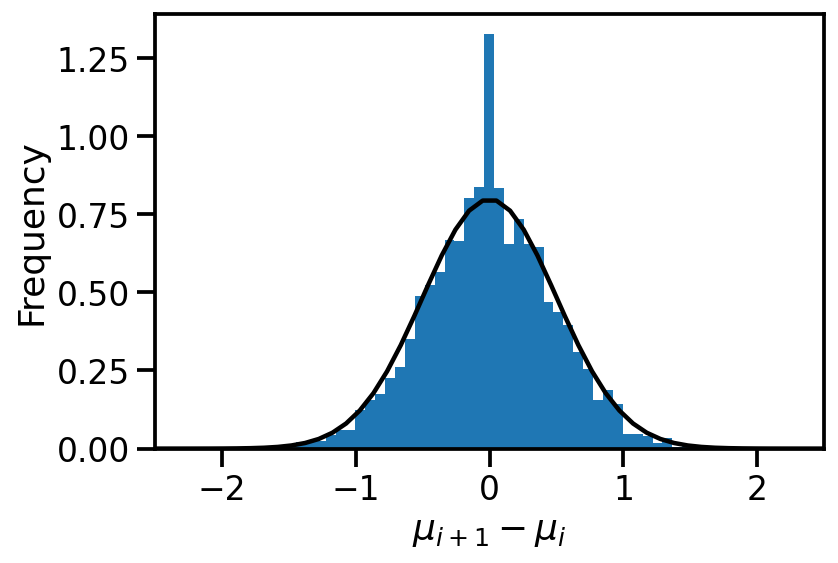

In [26]:
diff = μ_samples[1:] - μ_samples[:-1]
plt.hist(diff, bins=50, density=True)
diff_range = np.linspace(-η*5, η*5)
plt.plot(diff_range, scipy.stats.norm.pdf(diff_range, 0, η), color='k')
plt.xlim(-η*5, η*5)
plt.xlabel(r'$\mu_{i+1}-\mu_i$')
plt.ylabel('Frequency');

This is important because it means that our samples are correlated. We want to make sure that they are weakly correlated -- that the correlation is lost after a few iterations

We can check the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation), which is a measure of how much sample $i$ is correlated with sample $i+k$ (with lag $k$). We want to check that the correlation quickly goes down with $k$.

We can see that here that is the case and that the autocorrelation goes down with the lag $k$.

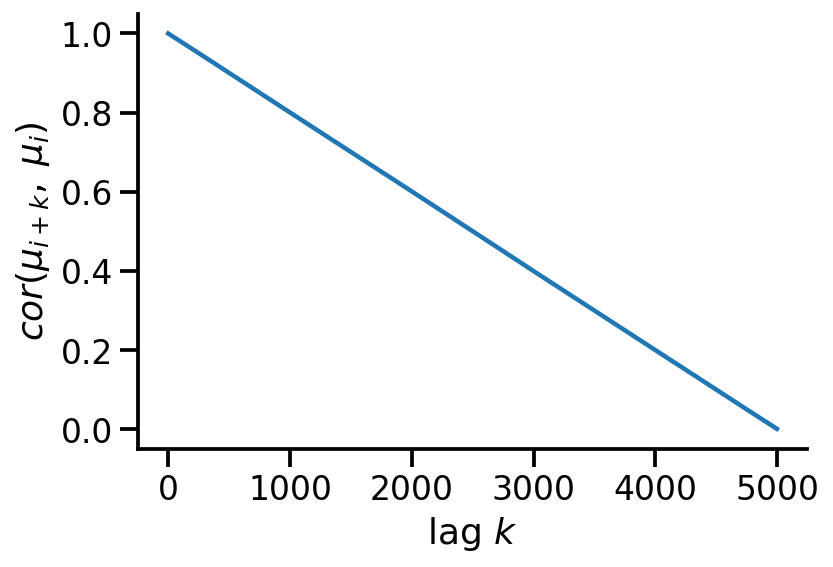

In [27]:
autocorr = np.correlate(μ_samples, μ_samples, mode='full')
autocorr /= autocorr.max()
autocorr = autocorr[autocorr.size // 2 :]

plt.plot(autocorr)
plt.xlabel('lag $k$')
plt.ylabel('$cor(\mu_{i+k}, \; \mu_i)$')
sns.despine()

## emcee: The MCMC Hammer

Now that we understand how sampling could work, we will use a more sophisticated an [affine-invariant ensemble sampler for Markov chain Monte Carlo (MCMC)](https://arxiv.org/abs/1202.3665): the **[emcee](https://emcee.readthedocs.io/)** package.

To setup the sampler, we generate some random starting guesses for multiple chains of samples.

In [104]:
ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# we'll start at random locations between 0 and 2000
guesses = 2000 * np.random.rand(nwalkers, ndim)

In [105]:
sampler = emcee.EnsembleSampler(
    nwalkers=nwalkers, 
    ndim=ndim,
    log_prob_fn=log_posterior,
    args=[X]
)
sampler.run_mcmc(
    initial_state=guesses,
    nsteps=nsteps
)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
# discard burn-in points and flatten with ravel()
sample = sampler.chain[:, nburn:, :].ravel()

If this all worked correctly, the array `sample` should contain a series of 50000 points drawn from the posterior. Let's plot them and check.

In [115]:
μ_hat = sample.mean()
σ_hat = sample.std()

print("μ = {} \nμ_hat = {} +/- {}".format(
    μ, μ_hat, σ_hat))

μ = 1000 
μ_hat = 999.170028734124 +/- 4.554674566002863


Before examining the posterior distribution, lets look at the trace plot, which shows:
1. the posterior distributions for each chain
1. the samples for each chain -- the $\mu$ sample values across time.

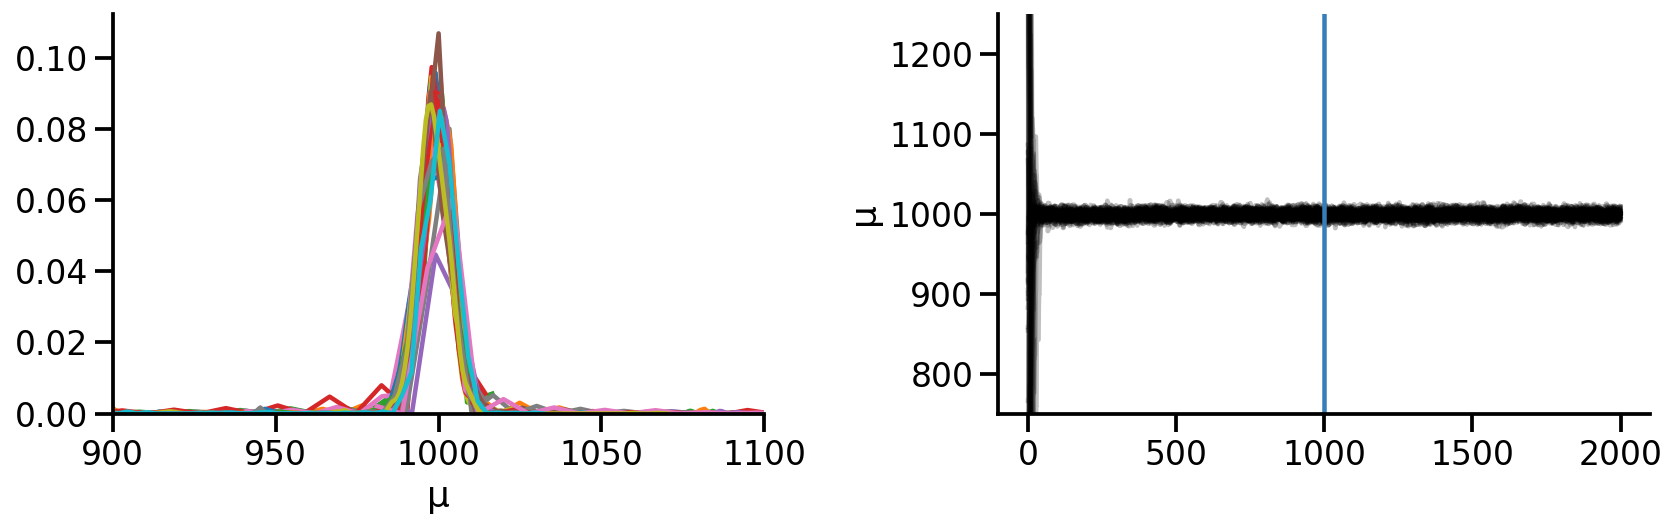

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for i in range(50):
    sns.kdeplot(sampler.chain[i,:,0], ax=axes[0])
axes[0].set_xlabel('μ')
axes[0].set_xlim(900, 1100)

ax = axes[1]
ax.plot(sampler.chain[:,:,0].T, color='k', alpha=0.25);
ax.axvline(nburn, color=blue)
ax.set_ylabel('μ')
ax.set_ylim(750, 1250)

fig.tight_layout()
sns.despine()

You can see here why we need to remove the initial `nburn` samples (or maybe less of them). 

Now we can plot the posterior distribution:

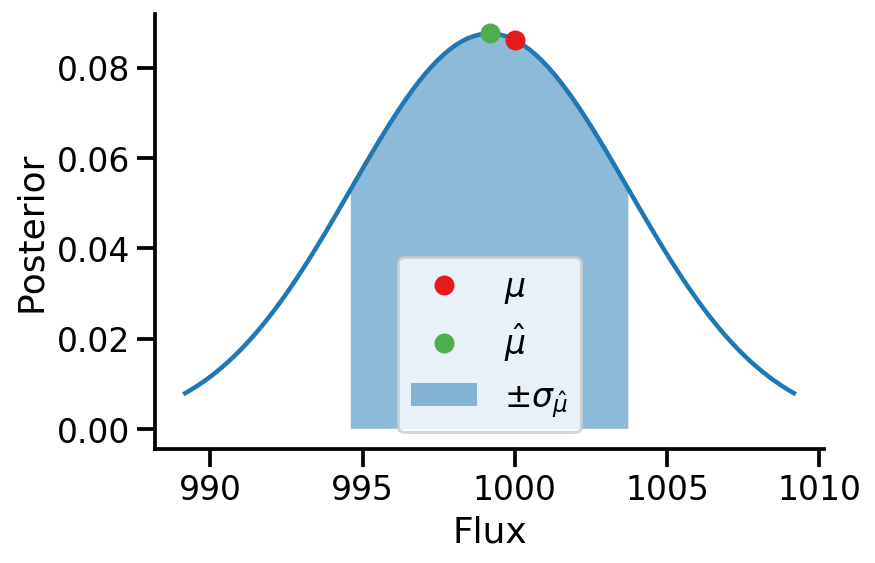

In [120]:
# fit normal distribution on the posterior sample
norm = scipy.stats.norm(*scipy.stats.norm.fit(sample)) 

μ_range = np.linspace(μ_hat*0.99, μ_hat*1.01, 100)
plt.plot(μ_range, norm.pdf(μ_range))
plt.plot(μ, norm.pdf(μ), 'o', color=red, label='$\mu$')
plt.plot(μ_hat, norm.pdf(μ_hat), 'o', color=green, label='$\hat{\mu}$')
μ_range = np.linspace(μ_hat-σ_hat, μ_hat+σ_hat)
plt.fill_between(μ_range, 0, [norm.pdf(μ_) for μ_ in μ_range], 
                 alpha=0.5, label='$\pm \sigma_{\hat{\mu}}$')

plt.xlabel("Flux")
plt.ylabel("Posterior")
plt.legend()
sns.despine()

For this simple problem, both approaches yield the same result, more or less.

# Complex model for photon count

We now assume that the light source is dynamic and stochastic (e.g. Quasar).

That is, the measurements $\{X_i\}$ are still drawn from a Poisson distribution, but the expectation ($F$) changes over time -- it is drawn from a normal distrubtion with expectation $\mu$ and standard deviation $\sigma$:
$$
F_i \sim N(\mu, \sigma) \\
X_i \sim Poi(F)
$$

We note the model parameters as $\theta = (\mu, \sigma)$.

Let's generate data according to this model.

In [9]:
# for reproducibility
np.random.seed(42)
# we'll use more samples for the complex model
n = 100  
# parameters stochastic flux model
θ = (μ, σ) = 1000, 15
# (unknown) true flux
F = np.random.normal(μ, σ, size=n)
# observed flux: true flux plus Poisson errors
X = np.random.poisson(F)

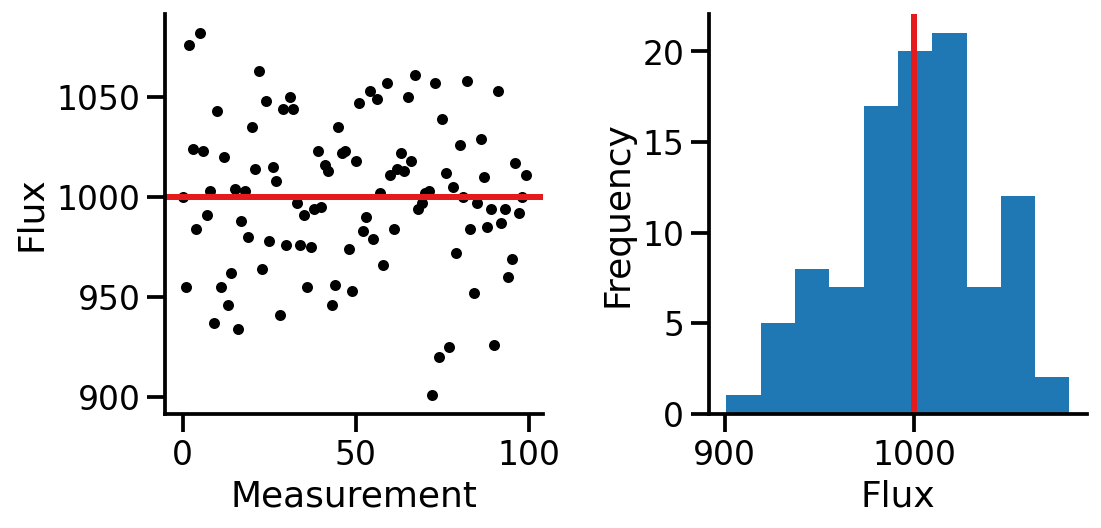

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

ax = axes[0]
ax.plot(np.arange(n), X, '.k')
ax.axhline(μ, linewidth=3, color=red)
ax.set_xlabel("Measurement")
ax.set_ylabel("Flux")

ax = axes[1]
ax.hist(X, bins=10)
ax.axvline(μ, linewidth=3, alpha=1, color=red)
ax.set_ylabel("Frequency")
ax.set_xlabel("Flux")

fig.tight_layout()
sns.despine()

Again, we have already written the log-likelihood function:

In [11]:
def log_likelihood(θ, X):
    μ, σ = θ
    return -0.5 * (np.log(2 * np.pi * (σ**2 + X)) + (X - μ) ** 2 / (σ**2 + X)).sum()
log_likelihood(θ, X)

-503.223428772118

We used SciPy's optimization routines to find the maximum likelihood (and then bootstrap to find confidence intervals).

In [12]:
def neg_log_likelihood(θ, X):
    return -log_likelihood(θ, X)

θ_guess = (900, 5)
θ_hat = scipy.optimize.fmin(
    func=neg_log_likelihood, 
    x0=θ_guess, 
    args=(X,)
)
μ_hat, σ_hat = θ_hat
print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114
μ = 1000 	μ_hat = 999.23
σ = 15		σ_hat = 19.35


## Bayesian inference

This is very similar to the previous case, with minor modifications to introduce the second parameter $\sigma$.

In [13]:
def log_prior(θ):
    μ, σ = θ
    # both parameters need to be positive
    if μ > 0 and σ > 0:
        return 0
    else:
        return -np.inf

def log_posterior(θ, X):
    pri = log_prior(θ)
    if np.isinf(pri): 
        return pri
    return pri + log_likelihood(θ, X)

In [14]:
ndim, nwalkers = 2, 50
nsteps, nburn = 1000, 500

guesses = np.random.rand(nwalkers, ndim)
guesses[:, 0] *= 2000  # start mu between 0 and 2000
guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[X])
sampler.run_mcmc(guesses, nsteps)

# sampler.chain.shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)

In [15]:
μ_sample, σ_sample = sample[:,0], sample[:,1]
μ_hat, σ_hat = μ_sample.mean(), (σ_sample).mean()

print("μ = {} \tμ_hat = {:.2f}\nσ = {}\t\tσ_hat = {:.2f}".format(
    μ, μ_hat, σ, σ_hat))

μ = 1000 	μ_hat = 999.18
σ = 15		σ_hat = 18.82


These estimates are very similar to those of the frequentist approach.

Lets check the trace plot first.

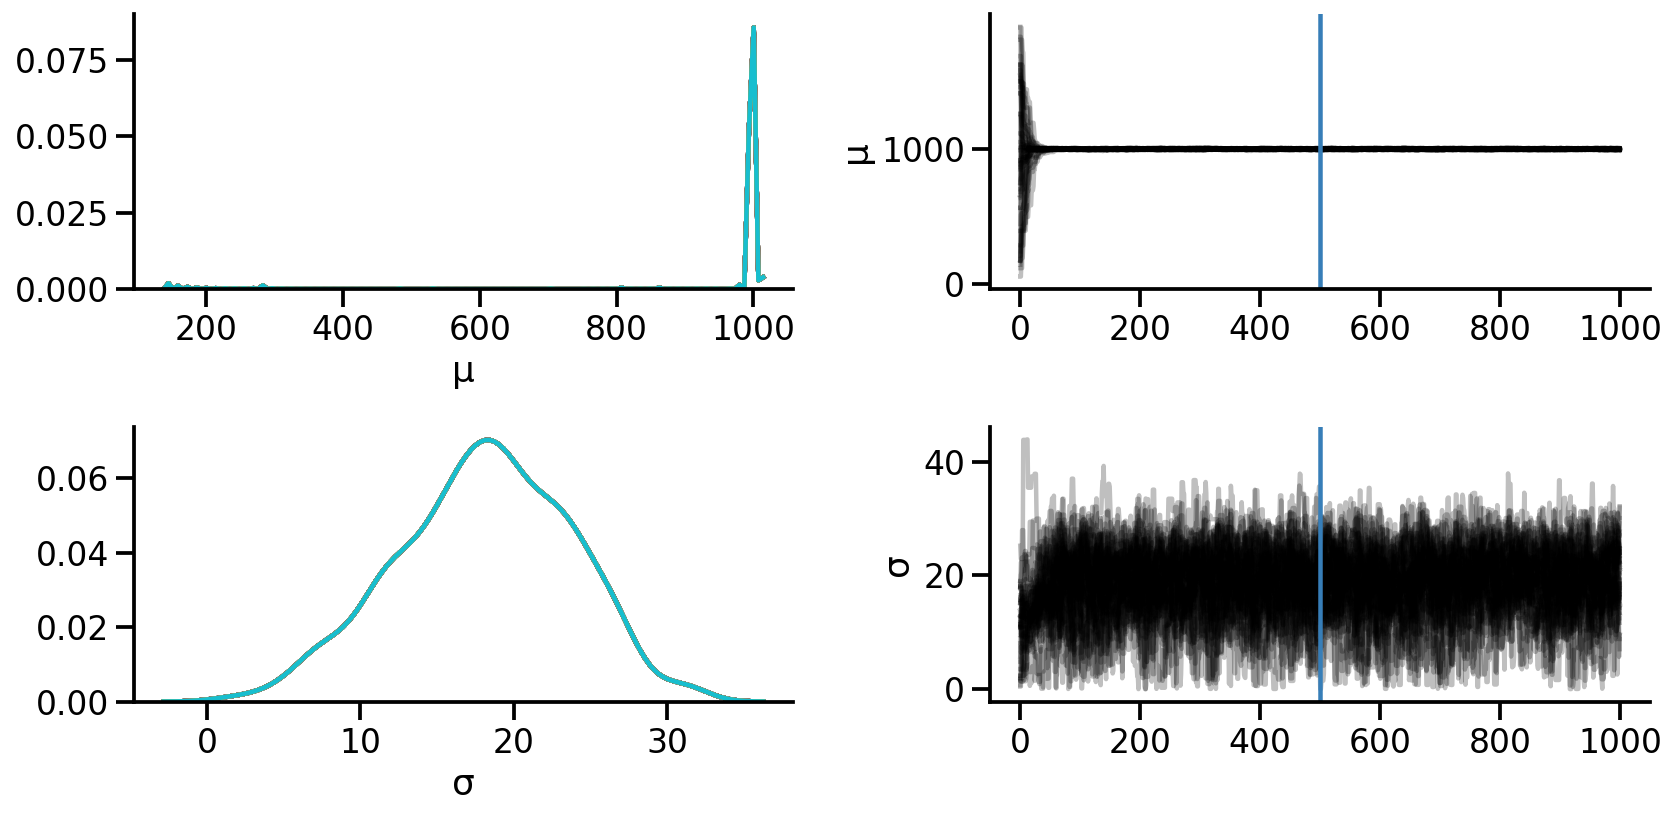

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for i, varname in enumerate(['μ', 'σ']):
    for j in range(sampler.chain.shape[0]):
        sns.kdeplot(sampler.chain[i,:,i], ax=axes[i,0])
    axes[i,0].set_xlabel(varname)

for i, varname in enumerate(['μ', 'σ']):
    ax = axes[i,1]
    ax.plot(sampler.chain[:,:,i].T, color='k', alpha=0.25);
    ax.axvline(nburn, color=blue)
    ax.set_ylabel(varname)

fig.tight_layout()
sns.despine()

Looks about right.

Lets plot the posterior distribution. 
To do that, we estimate the joint distribution using a kernel density estimator.

In [17]:
N = 100
kde = scipy.stats.gaussian_kde([μ_sample, σ_sample])
μ_range = np.linspace(980, 1020, N)
σ_range = np.linspace(0, 40, N)
θ_range = np.array([[(μ, σ) for μ in μ_range] for σ in σ_range])
θ_range = θ_range.reshape((-1, 2)).T
density = kde(θ_range)
density = density.reshape((N, N))

We plot the marginal posterior distributions of $\mu$ and $\sigma$ on the diagonal as histograms, with normal distributions fitted over them.

We also plot the joint posterior distributions, once as contours with the samples as dots, and once with a colored plot where yellow is high density and purple is low density.

In all plots, the red and green markers show the true and sample mean of the parameters.

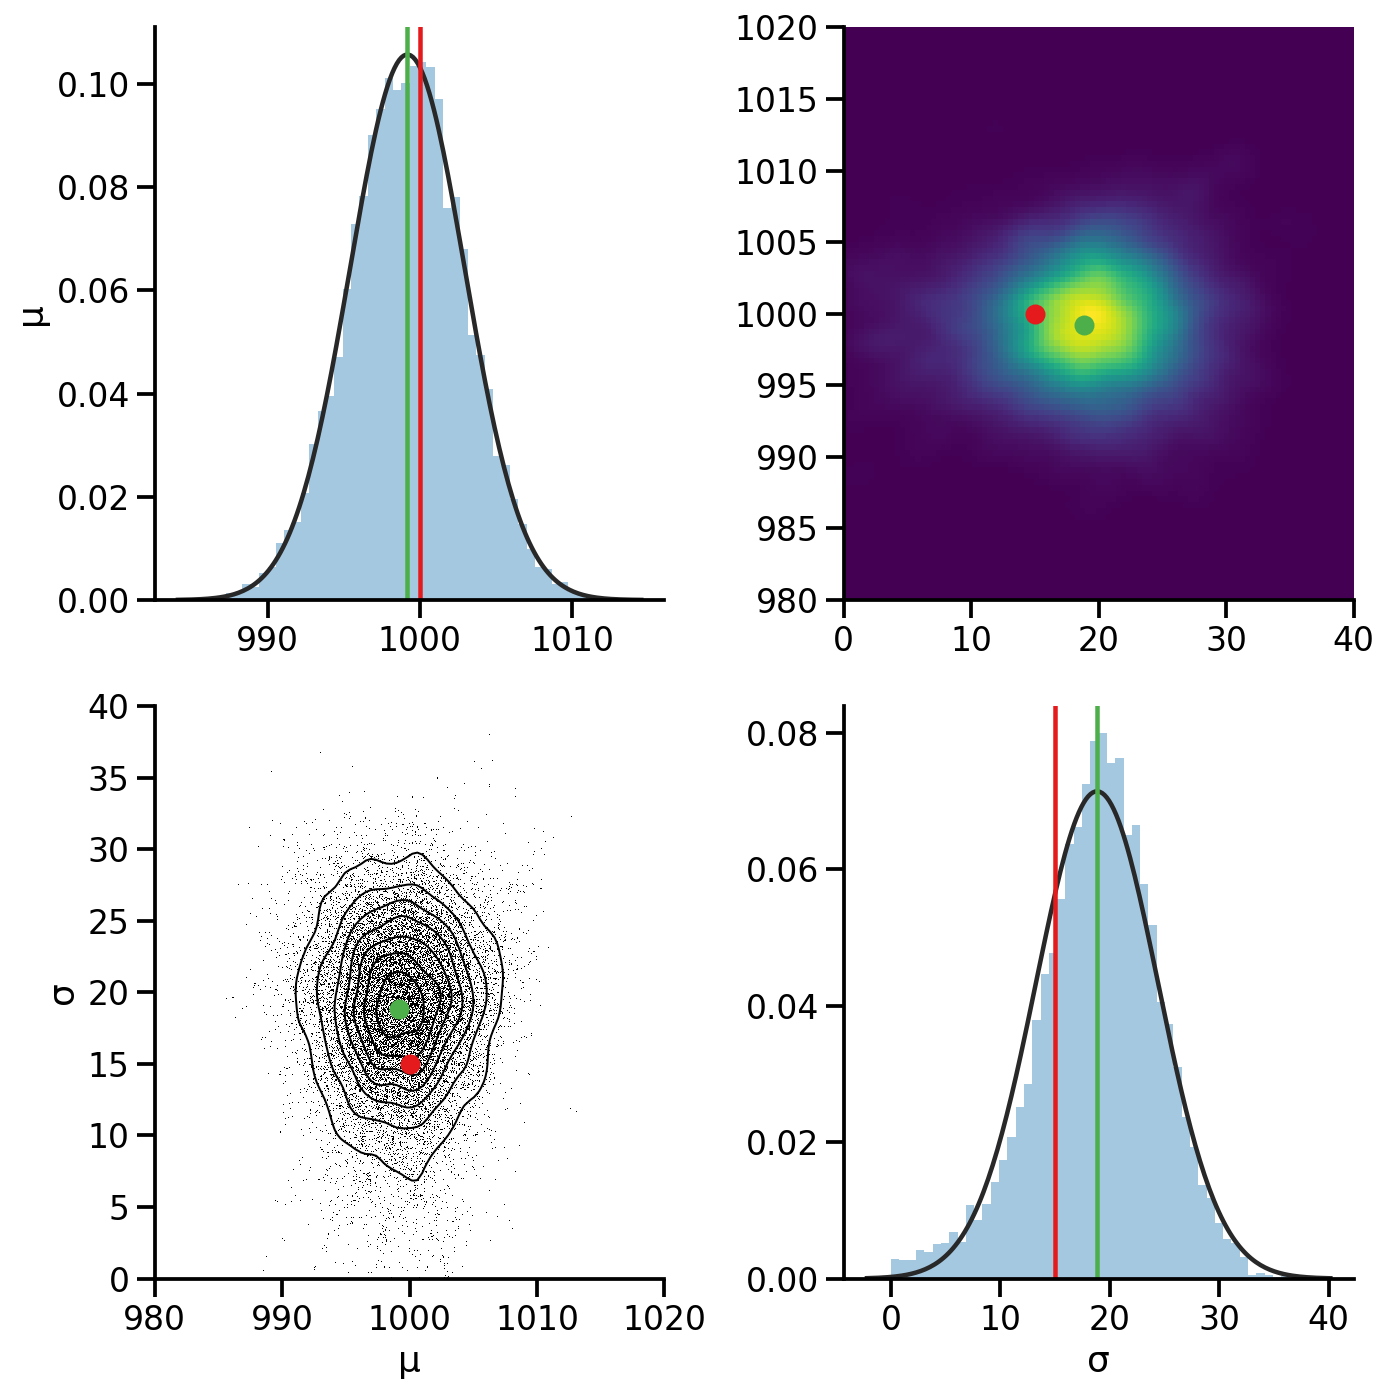

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# marginal
sns.distplot(μ_sample, bins=50, fit=scipy.stats.norm, kde=False, ax=axes[0,0])
sns.distplot(σ_sample, bins=50, fit=scipy.stats.norm, kde=False, ax=axes[1,1])

axes[0,0].axvline(μ, color=red)
axes[0,0].axvline(μ_hat, color=green)
axes[1,1].axvline(σ, color=red)
axes[1,1].axvline(σ_hat, color=green)

# joint
axes[0,1].pcolormesh(σ_range, μ_range, density.T)
axes[0,1].plot(σ, μ, color=red, marker='o')
axes[0,1].plot(σ_hat, μ_hat, color=green, marker='o')

axes[1,0].plot(μ_sample, σ_sample, ',k')
axes[1,0].plot(μ, σ, color=red, marker='o')
axes[1,0].plot(μ_hat, σ_hat, color=green, marker='o')
axes[1,0].contour(μ_range, σ_range, density, colors='k', linewidths=1)


axes[0,0].set(ylabel='μ')
axes[0,1].set()
axes[1,0].set(xlabel='μ', ylabel='σ')
axes[1,1].set(xlabel='σ')


fig.tight_layout()
sns.despine()

You can see that the marginal posterior of $\mu$ fits a normal distribution very nicely, but the posterior of $\sigma$ not so much, which makes sense, because it is bounded by 0 on the left. This might also bias our estimate, which is made with a mean.

We can also get a similar plot using the [corner](http://corner.readthedocs.io) package.

Here, the contours on the joint plot show one and two standard deviations (of a gaussian) to demonstrate confidence regions. This demonstrates that the truth is just on the edge of the confidence region.

In [19]:
from corner import corner 

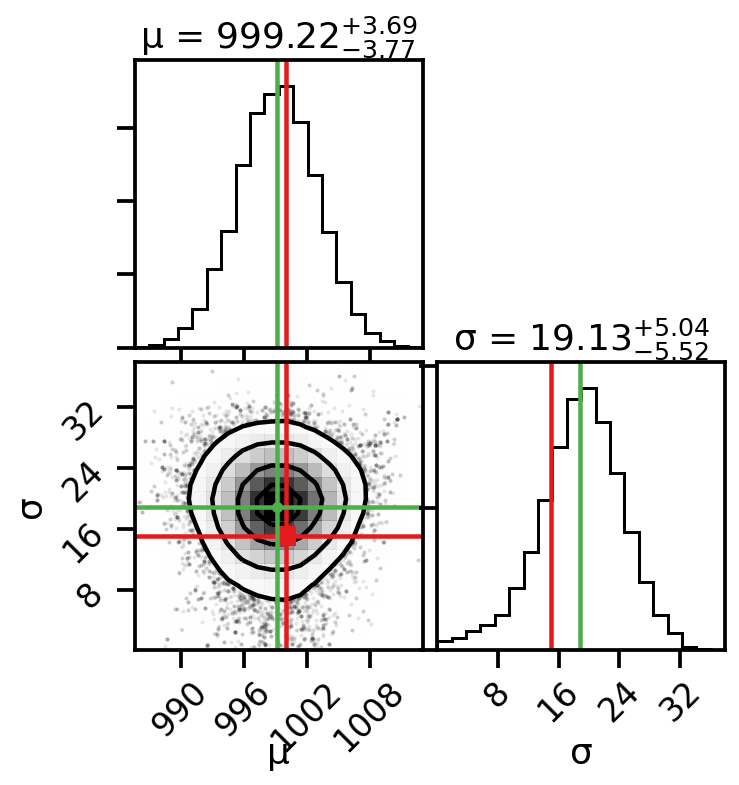

In [22]:
cor = corner(sample, 
    smooth=True,
    labels=['μ', 'σ'],
    truths=[μ, σ],
    truth_color=red,
    show_titles=True,
)
cor.axes[0].axvline(μ_hat, color=green)
cor.axes[3].axvline(σ_hat, color=green)
cor.axes[2].axvline(μ_hat, color=green)
cor.axes[2].axhline(σ_hat, color=green)
cor.axes[2].plot(μ_hat, σ_hat, '.', color=green);

This is very similar to what we found using bootstrap and maximum likelihood: this shows that in many cases the frequentist and Bayesian approaches can lead to similar results using different approachs.

# References

- Jake VanDerPlas's series of [blog posts on Bayesian inference](http://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/)
- Cam Davidson-Pilon's book [Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/)
- [emcee](https://emcee.readthedocs.io/)
- [corner](http://corner.readthedocs.io/)
- [ArviZ](https://arviz-devs.github.io/arviz)

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Scientific Computing with Python_](https://scicompy.yoavram.com/) course at IDC Herzliya.

The notebook was written using [Python](http://python.org/) 3.6.5.
Dependencies listed in [environment.yml](../environment.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)